In [8]:
import torch
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils.data import DataLoader,  ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import random
import time
import os
import shutil
from PIL import Image
import imagehash
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [9]:
BASE_DATA_PATH = "/kaggle/input/kelasor-77/Kelaasor_r_7000"
TRAIN = os.path.join(BASE_DATA_PATH, "train")
VALID = os.path.join(BASE_DATA_PATH, "validation")
TEST = os.path.join(BASE_DATA_PATH, "test")
MODEL_SAVE_PATH = "/kaggle/working/beast.pth"

## 📦 Remove Duplicate Images Using Image Hashing

In [3]:
# source = r"C:\Users\user\Downloads\task 3 deep\Kelaasor_vegetable_images_dataset"
# target = r"C:\Users\user\Downloads\task 3 deep\Kelaasor_vegetable_images_7000"

# def remove_duplicates_by_hash(source, target):
#     if not os.path.exists(target):
#         os.makedirs(target)

#     class_names = sorted(os.listdir(source))

#     for class_name in tqdm(class_names, desc="Processing classes"):
#         class_path = os.path.join(source, class_name)
#         target_class_path = os.path.join(target, class_name)
#         os.makedirs(target_class_path, exist_ok=True)

#         seen_hashes = set()
#         image_files = os.listdir(class_path)

#         for img_name in image_files:
#             img_path = os.path.join(class_path, img_name)

#             try:
#                 with Image.open(img_path) as img:
#                     img_hash = str(imagehash.average_hash(img))
#             except:
#                 continue

#             if img_hash not in seen_hashes:
#                 seen_hashes.add(img_hash)
#                 shutil.copy2(img_path, os.path.join(target_class_path, img_name))

#     print("✅ Done:", target)

# remove_duplicates_by_hash(source, target)

In [4]:
NUM_CLASSES = 15
BATCH_SIZE = 32
NUM_WORKERS = 4
INITIAL_LR = 1e-3
FINETUNE_LR = 2e-5
WEIGHT_DECAY = 1e-4
CLASSIFIER_EPOCHS = 5
EARLY_LAYERS_EPOCHS = 5
FINETUNE_EPOCHS = 20
DROPOUT_RATE = 0.5

 ### 🧪 Custom Data Augmentation Classes


In [5]:
class AddSaltAndPepperNoise:
    def __init__(self, amount=0.01, salt_vs_pepper=0.5, p=0.5):
        self.amount = amount
        self.salt_vs_pepper = salt_vs_pepper
        self.p = p
    def __call__(self, tensor):
        if torch.rand(1) >= self.p: return tensor
        noisy_tensor = tensor.clone()
        c, h, w = noisy_tensor.shape
        num_pixels = int(self.amount * h * w)
        num_salt = int(num_pixels * self.salt_vs_pepper)
        num_pepper = num_pixels - num_salt
        salt_coords_h = torch.randint(0, h, (num_salt,))
        salt_coords_w = torch.randint(0, w, (num_salt,))
        noisy_tensor[:, salt_coords_h, salt_coords_w] = 1.0
        pepper_coords_h = torch.randint(0, h, (num_pepper,))
        pepper_coords_w = torch.randint(0, w, (num_pepper,))
        noisy_tensor[:, pepper_coords_h, pepper_coords_w] = 0.0
        return noisy_tensor

class AddGaussianNoise:
    def __init__(self, mean=0., std=0.1, p=0.5):
        self.std = std
        self.mean = mean
        self.p = p
    def __call__(self, tensor):
        if torch.rand(1) >= self.p: return tensor
        noise = torch.randn(tensor.size(), device=tensor.device) * self.std + self.mean
        return torch.clamp(tensor + noise, 0., 1.)

### 🌀 Data Augmentation Pipelines

In [6]:
preprocess_augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=30, translate=(0.15, 0.15), scale=(0.7, 1.3), shear=15)
    ], p=0.5),
    transforms.ColorJitter(brightness=0.9, contrast=0.7, saturation=0.7, hue=0.3),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=(7, 15), sigma=(1.0, 8.0))
    ], p=0.6),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([
        transforms.RandomPosterize(bits=2)
    ], p=0.2),
    transforms.RandomSolarize(threshold=0.5, p=0.1),
    transforms.ToTensor(),
    AddSaltAndPepperNoise(amount=0.07, salt_vs_pepper=0.5, p=0.6),
    AddGaussianNoise(mean=0.0, std=0.15, p=0.5),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])




simple_augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # gentler cropping
    transforms.RandomHorizontalFlip(p=0.5),               # keep horizontal flip
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),  # subtle color shifts
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.0, std=0.05, p=0.3),           # low Gaussian noise
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

    
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])




### 🧠 Dataset and DataLoader Setup

In [10]:
simple_aug_dataset = ImageFolder(root=TRAIN, transform=simple_augment)
strong_aug_dataset = ImageFolder(root=TRAIN, transform=preprocess_augment)
combined_dataset = ConcatDataset([simple_aug_dataset, strong_aug_dataset])

val_dataset = ImageFolder(VALID, transform=preprocess)
test_dataset = ImageFolder(TEST, transform=preprocess)

train_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

### 🎨 Visualizing Augmented Training Images

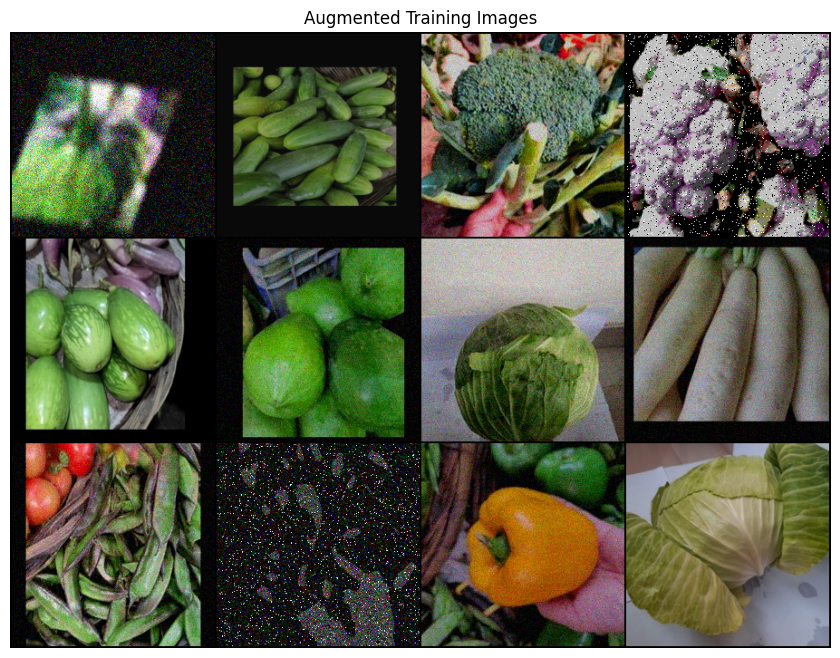

In [17]:
NUM_IMAGES = 12

visualize_loader = DataLoader(combined_dataset, batch_size=NUM_IMAGES, shuffle=True)

images, labels = next(iter(visualize_loader))

mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
images = images * std + mean  # Unnormalize

plt.figure(figsize=(15, 8))
grid_img = make_grid(images, nrow=4)
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title("Augmented Training Images")
plt.show()


## 🧠 Phase 5: Model Loading and Modification

In [12]:
# Phase 5: Model Loading and Modification

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[1].in_features 
model.classifier[1] = nn.Sequential(
    nn.Dropout(p=DROPOUT_RATE),
    nn.Linear(num_ftrs, NUM_CLASSES) 
)

model = model.to(device)

print("Model loaded, classifier replaced, and moved to device.")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 155MB/s]


Model loaded, classifier replaced, and moved to device.


## 🔁 Phase 6: Training and Evaluation Functions


In [13]:
# Phase 6: Training and Evaluation Functions

loss_fn = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()  
    total_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(loader, leave=True)
    for x, y in loop:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad() 
        out = model(x)
        loss = loss_fn(out, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0) 
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)

        loop.set_description(f"Train Epoch")
        loop.set_postfix(loss=loss.item(), acc=f"{(preds == y).float().mean().item()*100:.2f}%")

    avg_loss = total_loss / total
    accuracy = (correct / total) * 100
    return avg_loss, accuracy

def eval_model(model, loader, loss_fn, device):
    model.eval() 
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        loop = tqdm(loader, leave=True)
        for x, y in loop:
            x, y = x.to(device), y.to(device) 

            out = model(x)
            loss = loss_fn(out, y)

            # Track metrics
            total_loss += loss.item() * x.size(0)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += x.size(0)

            # Update tqdm description
            loop.set_description(f"Eval ")
            loop.set_postfix(loss=loss.item(), acc=f"{(preds == y).float().mean().item()*100:.2f}%")

    avg_loss = total_loss / total
    accuracy = (correct / total) * 100
    return avg_loss, accuracy

## 🎯 Phase 7: Train Classifier Only


In [14]:
# Phase 7: Train Classifier Only

print("\n--- Starting Phase 1: Training Classifier Only ---")

optimizer_cls = optim.Adam(model.classifier[1].parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

start_time = time.time()
for epoch in range(CLASSIFIER_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{CLASSIFIER_EPOCHS}")
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer_cls, loss_fn, device)
    val_loss, val_acc = eval_model(model, val_loader, loss_fn, device)

    print(f"  Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accuracies.append(tr_acc)
    val_accuracies.append(val_acc)

phase1_time = time.time() - start_time
print(f"--- Phase 1 finished in {phase1_time // 60:.0f}m {phase1_time % 60:.0f}s ---")


--- Starting Phase 1: Training Classifier Only ---

Epoch 1/5


Eval : 100%|██████████| 94/94 [00:08<00:00, 11.14it/s, acc=95.83%, loss=0.232] 


  Train Loss: 1.5770, Train Acc: 51.89%
  Val Loss:   0.3480, Val Acc:   90.73%

Epoch 2/5


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.35it/s, acc=95.83%, loss=0.109]  


  Train Loss: 1.4435, Train Acc: 56.52%
  Val Loss:   0.3202, Val Acc:   91.27%

Epoch 3/5


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.25it/s, acc=91.67%, loss=0.236]  


  Train Loss: 1.4199, Train Acc: 57.41%
  Val Loss:   0.3209, Val Acc:   90.57%

Epoch 4/5


Eval : 100%|██████████| 94/94 [00:05<00:00, 16.62it/s, acc=95.83%, loss=0.116]  


  Train Loss: 1.4394, Train Acc: 57.05%
  Val Loss:   0.2997, Val Acc:   91.23%

Epoch 5/5


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.77it/s, acc=95.83%, loss=0.108]  


  Train Loss: 1.4418, Train Acc: 57.00%
  Val Loss:   0.2927, Val Acc:   91.83%
--- Phase 1 finished in 12m 5s ---


## 🔧 Phase 8: Train Early Layers + Classifier

In [15]:
# Phase 8: Train Early Layers + Classifier

print("\n--- Starting Phase 2: Training Early Layers + Classifier ---")

# Unfreeze early layers (e.g., first 5 feature blocks)
layers_to_unfreeze = 5
ct = 0
for name, child in model.features.named_children():
    if ct < layers_to_unfreeze:
        print(f"Unfreezing: {name}")
        for param in child.parameters():
            param.requires_grad = True
        ct += 1
    else:
        for param in child.parameters():
            param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer_early = optim.Adam(trainable_params, lr=FINETUNE_LR / 5, weight_decay=WEIGHT_DECAY) # Use a smaller LR

start_time = time.time()
# Continue training from the previous state
total_epochs_so_far = CLASSIFIER_EPOCHS
for epoch in range(EARLY_LAYERS_EPOCHS):
    current_epoch = total_epochs_so_far + epoch + 1
    print(f"\nEpoch {current_epoch}/{CLASSIFIER_EPOCHS + EARLY_LAYERS_EPOCHS + FINETUNE_EPOCHS}")
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer_early, loss_fn, device)
    val_loss, val_acc = eval_model(model, val_loader, loss_fn, device)

    print(f"  Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accuracies.append(tr_acc)
    val_accuracies.append(val_acc)

phase2_time = time.time() - start_time
print(f"--- Phase 2 finished in {phase2_time // 60:.0f}m {phase2_time % 60:.0f}s ---")


--- Starting Phase 2: Training Early Layers + Classifier ---
Unfreezing: 0
Unfreezing: 1
Unfreezing: 2
Unfreezing: 3
Unfreezing: 4

Epoch 6/30


Eval : 100%|██████████| 94/94 [00:05<00:00, 16.01it/s, acc=95.83%, loss=0.122]  


  Train Loss: 1.4012, Train Acc: 58.10%
  Val Loss:   0.2732, Val Acc:   92.30%

Epoch 7/30


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.92it/s, acc=100.00%, loss=0.101] 


  Train Loss: 1.3677, Train Acc: 58.95%
  Val Loss:   0.2632, Val Acc:   92.67%

Epoch 8/30


Eval : 100%|██████████| 94/94 [00:05<00:00, 16.83it/s, acc=100.00%, loss=0.0826]


  Train Loss: 1.3422, Train Acc: 59.36%
  Val Loss:   0.2578, Val Acc:   92.70%

Epoch 9/30


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.16it/s, acc=100.00%, loss=0.0694]


  Train Loss: 1.3527, Train Acc: 59.33%
  Val Loss:   0.2543, Val Acc:   92.73%

Epoch 10/30


Eval : 100%|██████████| 94/94 [00:05<00:00, 16.21it/s, acc=100.00%, loss=0.068] 

  Train Loss: 1.3376, Train Acc: 59.71%
  Val Loss:   0.2482, Val Acc:   93.00%
--- Phase 2 finished in 12m 47s ---


## 🚀 Phase 9: Full Fine-tuning


In [16]:
# Phase 9: Full Fine-tuning

print("\n--- Starting Phase 3: Full Fine-tuning ---")

for param in model.parameters():
    param.requires_grad = True

optimizer_ft = optim.Adam(model.parameters(), lr=FINETUNE_LR, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.2, patience=3, verbose=True)

start_time = time.time()
total_epochs_so_far = CLASSIFIER_EPOCHS + EARLY_LAYERS_EPOCHS
for epoch in range(FINETUNE_EPOCHS):
    current_epoch = total_epochs_so_far + epoch + 1
    print(f"\nEpoch {current_epoch}/{CLASSIFIER_EPOCHS + EARLY_LAYERS_EPOCHS + FINETUNE_EPOCHS}")
    print(f"Current LR: {optimizer_ft.param_groups[0]['lr']:.2e}") # Display current learning rate

    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer_ft, loss_fn, device)
    val_loss, val_acc = eval_model(model, val_loader, loss_fn, device)

    print(f"  Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")

    scheduler.step(val_loss)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accuracies.append(tr_acc)
    val_accuracies.append(val_acc)

phase3_time = time.time() - start_time
print(f"--- Phase 3 finished in {phase3_time // 60:.0f}m {phase3_time % 60:.0f}s ---")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



--- Starting Phase 3: Full Fine-tuning ---

Epoch 11/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 16.64it/s, acc=100.00%, loss=0.00877]


  Train Loss: 1.0001, Train Acc: 68.72%
  Val Loss:   0.1095, Val Acc:   96.87%

Epoch 12/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 16.81it/s, acc=100.00%, loss=0.003]  


  Train Loss: 0.7820, Train Acc: 75.47%
  Val Loss:   0.0707, Val Acc:   97.80%

Epoch 13/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.03it/s, acc=100.00%, loss=0.00124] 


  Train Loss: 0.6820, Train Acc: 78.62%
  Val Loss:   0.0590, Val Acc:   98.23%

Epoch 14/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.78it/s, acc=100.00%, loss=0.00116] 


  Train Loss: 0.6069, Train Acc: 81.13%
  Val Loss:   0.0487, Val Acc:   98.43%

Epoch 15/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.73it/s, acc=100.00%, loss=0.000224]


  Train Loss: 0.5489, Train Acc: 82.91%
  Val Loss:   0.0396, Val Acc:   98.73%

Epoch 16/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 16.36it/s, acc=100.00%, loss=0.000305]


  Train Loss: 0.5121, Train Acc: 84.24%
  Val Loss:   0.0376, Val Acc:   98.87%

Epoch 17/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.80it/s, acc=100.00%, loss=0.000255]


  Train Loss: 0.4860, Train Acc: 84.84%
  Val Loss:   0.0307, Val Acc:   99.07%

Epoch 18/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.93it/s, acc=100.00%, loss=0.000647]


  Train Loss: 0.4527, Train Acc: 86.17%
  Val Loss:   0.0261, Val Acc:   99.20%

Epoch 19/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.57it/s, acc=100.00%, loss=0.001]   


  Train Loss: 0.4306, Train Acc: 86.76%
  Val Loss:   0.0289, Val Acc:   99.13%

Epoch 20/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 15.99it/s, acc=100.00%, loss=0.00108] 


  Train Loss: 0.4106, Train Acc: 87.20%
  Val Loss:   0.0227, Val Acc:   99.23%

Epoch 21/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.46it/s, acc=100.00%, loss=0.000638]


  Train Loss: 0.3899, Train Acc: 87.98%
  Val Loss:   0.0232, Val Acc:   99.43%

Epoch 22/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.12it/s, acc=100.00%, loss=0.00141] 


  Train Loss: 0.3813, Train Acc: 88.15%
  Val Loss:   0.0235, Val Acc:   99.27%

Epoch 23/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.56it/s, acc=100.00%, loss=0.00344] 


  Train Loss: 0.3688, Train Acc: 88.53%
  Val Loss:   0.0222, Val Acc:   99.37%

Epoch 24/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.23it/s, acc=100.00%, loss=0.00114] 


  Train Loss: 0.3479, Train Acc: 89.16%
  Val Loss:   0.0212, Val Acc:   99.33%

Epoch 25/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.60it/s, acc=100.00%, loss=0.00184] 


  Train Loss: 0.3515, Train Acc: 89.12%
  Val Loss:   0.0241, Val Acc:   99.27%

Epoch 26/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.94it/s, acc=100.00%, loss=0.00619] 


  Train Loss: 0.3337, Train Acc: 89.64%
  Val Loss:   0.0182, Val Acc:   99.43%

Epoch 27/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.13it/s, acc=100.00%, loss=0.002]   


  Train Loss: 0.3204, Train Acc: 89.92%
  Val Loss:   0.0165, Val Acc:   99.50%

Epoch 28/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.57it/s, acc=100.00%, loss=0.00106] 


  Train Loss: 0.3063, Train Acc: 90.55%
  Val Loss:   0.0168, Val Acc:   99.53%

Epoch 29/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 17.76it/s, acc=100.00%, loss=0.00562] 


  Train Loss: 0.3000, Train Acc: 90.59%
  Val Loss:   0.0157, Val Acc:   99.67%

Epoch 30/30
Current LR: 2.00e-05


Eval : 100%|██████████| 94/94 [00:05<00:00, 16.48it/s, acc=100.00%, loss=0.000416]

  Train Loss: 0.2958, Train Acc: 90.70%
  Val Loss:   0.0151, Val Acc:   99.50%
--- Phase 3 finished in 51m 15s ---


## 💾 Phase 10: Save the Trained Model


In [18]:
# Phase 10: Save the Trained Model

print(f"\nSaving model to {MODEL_SAVE_PATH}")
# Save the model's state dictionary
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("Model saved successfully.")



Saving model to /kaggle/working/beast.pth
Model saved successfully.


## 🚀 Phase 11: Evaluate on Test Set


In [19]:
# Phase 11: Evaluate on Test Set

print("\n--- Evaluating model on Test Set ---")
model.eval()  
y_true = []
y_pred = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy() 
        y_true.extend(y.numpy())
        y_pred.extend(preds)  

test_loss, test_acc = eval_model(model, test_loader, loss_fn, device) 
print(f"\nFinal Test Set Performance:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.2f}%")


--- Evaluating model on Test Set ---


Eval : 100%|██████████| 94/94 [00:05<00:00, 18.60it/s, acc=100.00%, loss=0.0192]  


Final Test Set Performance:
  Test Loss: 0.0399
  Test Accuracy: 98.77%


## 📊 Phase 12: Confusion Matrix Visualization



--- Generating Confusion Matrix ---


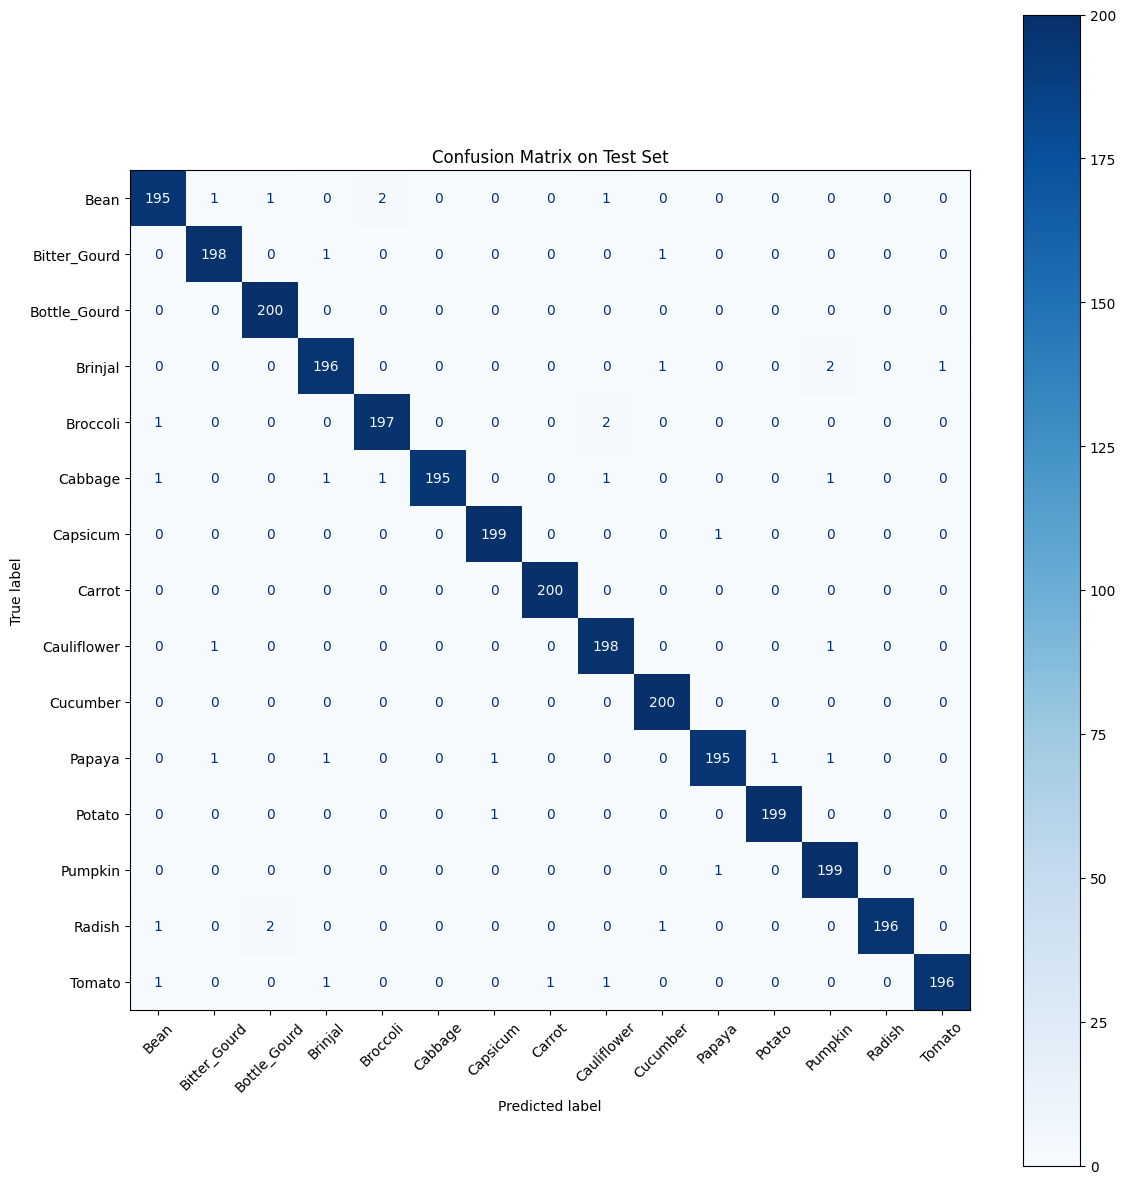

In [20]:
# Phase 12: Confusion Matrix Visualization

print("\n--- Generating Confusion Matrix ---")
class_names = test_dataset.classes

cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Blues) 
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

## 📈 Phase 13: Plot Training Curves



--- Plotting Training Loss and Accuracy Curves ---


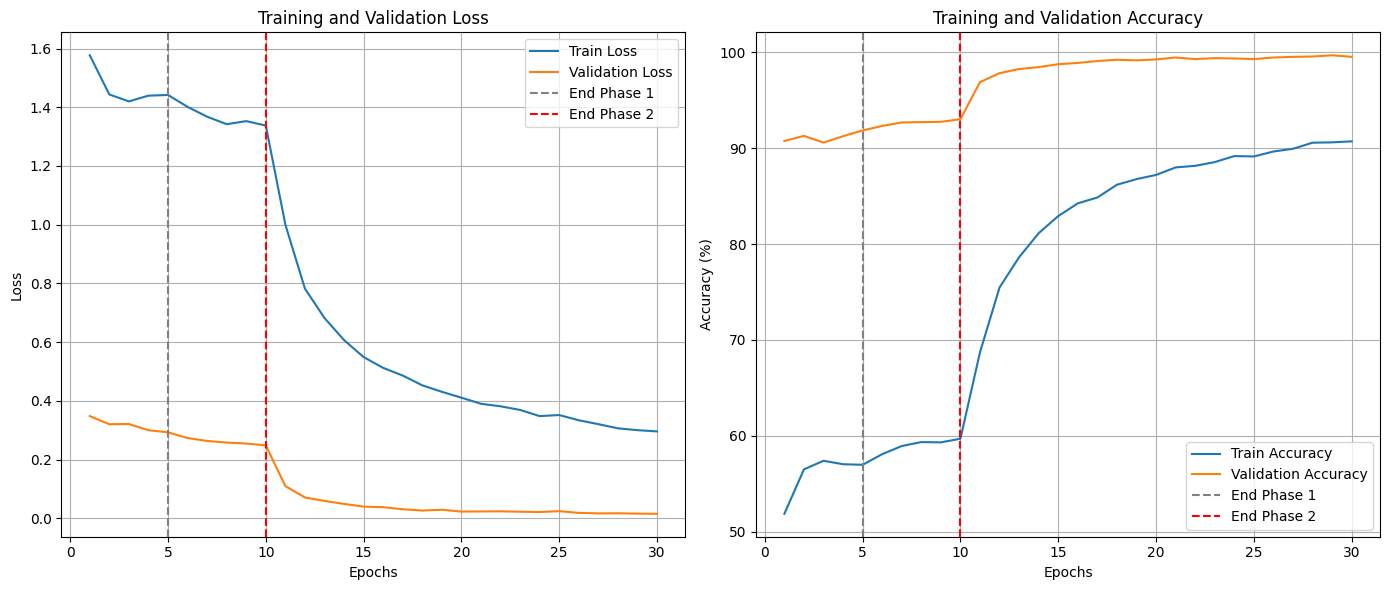

In [21]:
# Phase 13: Plot Training Curves

print("\n--- Plotting Training Loss and Accuracy Curves ---")
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.axvline(x=CLASSIFIER_EPOCHS, color='grey', linestyle='--', label='End Phase 1')
plt.axvline(x=CLASSIFIER_EPOCHS + EARLY_LAYERS_EPOCHS, color='red', linestyle='--', label='End Phase 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.axvline(x=CLASSIFIER_EPOCHS, color='grey', linestyle='--', label='End Phase 1')
plt.axvline(x=CLASSIFIER_EPOCHS + EARLY_LAYERS_EPOCHS, color='red', linestyle='--', label='End Phase 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## ❌ Phase 14: Visualize Misclassified Images


--- Analyzing Misclassified Images ---
Found 12 misclassified images to display.


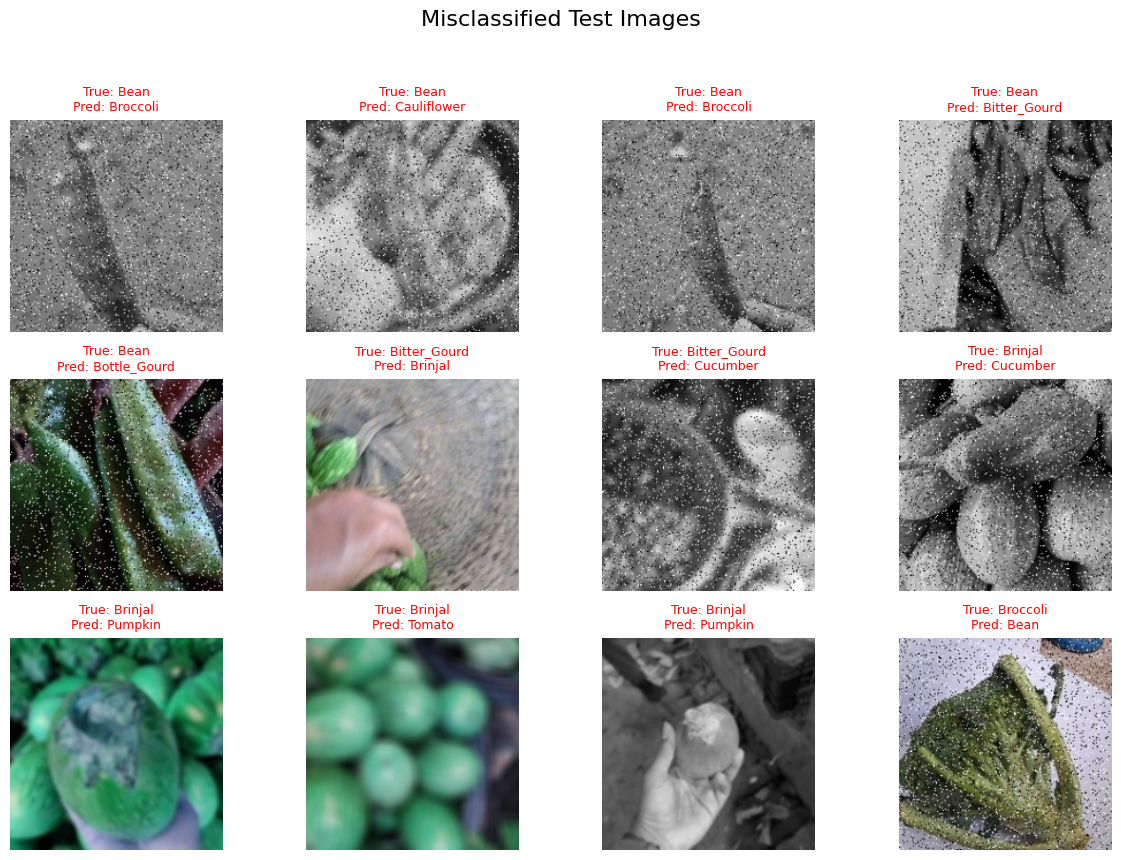

In [22]:
# Phase 14: Visualize Misclassified Images

print("\n--- Analyzing Misclassified Images ---")
misclassified_images = []
misclassified_preds = []
misclassified_labels = []
max_misclassified = 12 

model.eval() 
with torch.no_grad():
    for inputs, labels in test_loader: 
        inputs_device, labels_device = inputs.to(device), labels.to(device) 
        outputs = model(inputs_device)
        preds = torch.argmax(outputs, 1)

        mismatches = preds != labels_device
        mismatched_indices = torch.where(mismatches)[0] 

        for idx in mismatched_indices:
            if len(misclassified_images) < max_misclassified:
                misclassified_images.append(inputs[idx].cpu())
                misclassified_preds.append(preds[idx].item())
                misclassified_labels.append(labels[idx].item())
            else:
                break 

        if len(misclassified_images) >= max_misclassified:
            break 

print(f"Found {len(misclassified_images)} misclassified images to display.")

if misclassified_images:
    inv_normalize = transforms.Normalize(
       mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
       std=[1/0.229, 1/0.224, 1/0.225]
    )

    fig, axes = plt.subplots(math.ceil(max_misclassified / 4), 4, figsize=(12, math.ceil(max_misclassified / 4) * 3))
    fig.suptitle("Misclassified Test Images", fontsize=16)
    axes = axes.flatten() 
    for i, ax in enumerate(axes):
        if i < len(misclassified_images):
            img_tensor = misclassified_images[i]
            true_label_idx = misclassified_labels[i]
            pred_label_idx = misclassified_preds[i]

            img_unnormalized = inv_normalize(img_tensor)

            np_img = torch.clamp(img_unnormalized, 0, 1).permute(1, 2, 0).numpy()

            ax.imshow(np_img)
            true_label_name = test_dataset.classes[true_label_idx]
            pred_label_name = test_dataset.classes[pred_label_idx]
            ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}", color='red', fontsize=9)
            ax.axis('off')
        else:
             ax.axis('off') 

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No misclassified images found to display (or none were collected).")